In [1]:
import time
import numpy as np
import qiskit
from qiskit.opflow import X,Z,I
from qiskit.opflow.state_fns import StateFn, CircuitStateFn
from qiskit.providers.aer import StatevectorSimulator, AerSimulator
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.sparse.linalg.eigen.arpack as arp
from modules.utils import *

from tenpy.networks.mps import MPS
from tenpy.models.hubbard import BoseHubbardChain
from tenpy.algorithms import dmrg
from tenpy.linalg import np_conserved

%matplotlib inline

ModuleNotFoundError: No module named 'modules'

In [3]:
def DMRG_EBH(L, V, t_list, chi_max=30, bc_MPS='infinite'):

    model_params = dict(n_max=1, filling=0.5, bc_MPS=bc_MPS, t=t_list,
                        L=L, V=V, mu=0, conserve='N', verbose=0)
    M = BoseHubbardChain(model_params)
        
    vector=[]
    for i in range(M.lat.N_sites):
        if i%2:
            vector.append(1)
        else:
            vector.append(0)

    psi = MPS.from_product_state(M.lat.mps_sites(), vector, bc=M.lat.bc_MPS)    
        
    dmrg_params = {                                                                                             
        'mixer': True,                                                                                          
        'trunc_params': {                                                                                       
        'chi_max': chi_max,                                                                                                                                                                    
        },                                                                                                      
        'max_E_err': 1.e-16,                                                                                    
        'verbose': 0
    }
    
    info = dmrg.run(psi, M, dmrg_params)
    
    return info['E'], psi

## INFINITE

In [ ]:
chi = 50
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)
L = 4
mu = 0
deltat = 0.5
site = 0

psi_array = []

for deltat in deltat_list:
    
    print('deltat', deltat)
    t_list = np.ones(L)
    for i in range(len(t_list)):
        t_list[i] -= deltat*(-1)**i
    
    psi_0 = []
    for V in V_list:

        print('V', V)
        E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi)
        psi_0 = np.append(psi_0, psi0)

    psi_array.append(psi_0)
    
    np.save('data/BH_MPS.npy',  psi_array)

In [36]:
psi_array = np.load('data/BH_MPS.npy', allow_pickle=True)

ES_array = []
parity_array = []
dd_array = []

V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

for j,deltat in enumerate(deltat_list):
    
    ES_list = []
    parity_list = []
    dd_list = []

    psi_list = psi_array[j]
    
    for i,V in enumerate(V_list):
        
        psi = psi_list[i]
    
        ES = np.exp(-np.array(psi.entanglement_spectrum()[2]))
        dES = -np.sum(ES[::2])+np.sum(ES[1::2])
        ES_list.append(dES)
        
        dd = psi.expectation_value('dN')[2]
        dd_list.append(dd)
        
    dd_array.append(dd_list)
    ES_array.append(ES_list)

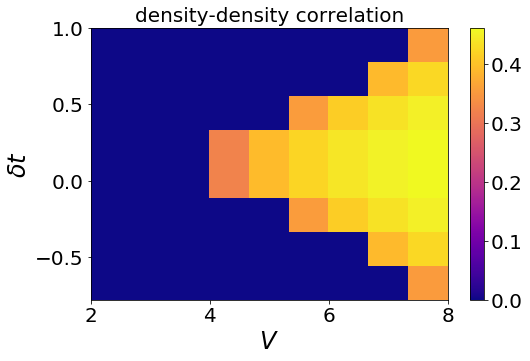

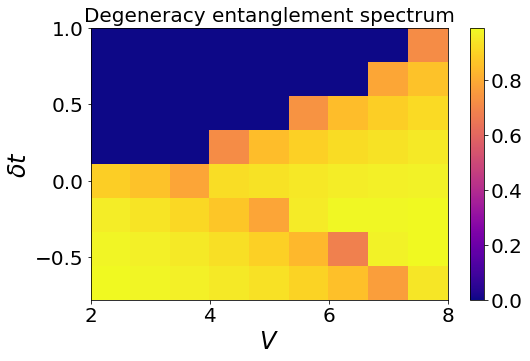

In [39]:
V_list = np.linspace(2,8,10)
deltat_list = np.linspace(-1,1,10)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(dd_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("density-density correlation",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(ES_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("Degeneracy entanglement spectrum",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)

# FINITE

In [ ]:
chi = 50
V_list = np.logspace(-2,2,10)
delta_listp= (1-np.logspace(-2,0,5))[::-1]
delta_listn = np.logspace(-2,0,5)-1
deltat_list = np.append(delta_listn, delta_listp)
#deltat_list = np.linspace(-0.95,0.95,10)
L = 10
mu = 0
site = 0

psi_array = []

for deltat in deltat_list:
    
    print('deltat', deltat)
    t_list = np.ones(L-1)
    for i in range(len(t_list)):
        t_list[i] -= deltat*(-1)**i
    
    psi_0 = []
    for V in V_list:

        print('V', V)
        E0, psi0 = DMRG_EBH(L, V, t_list, chi_max=chi, bc_MPS='finite')
        psi_0 = np.append(psi_0, psi0)

    psi_array.append(psi_0)
    
    np.save('data/BH_MPS_L%.0f_logV_logDeltat.npy' %L, psi_array)
    
wf_array = []
V_array = []
deltat_array = []

for i, deltat in enumerate(deltat_list):
    for j, V in enumerate(V_list):
        
        psi = psi_array[i][j]
        wf = psi.get_theta(0,L).to_ndarray().reshape(-1)
        wf_array.append(wf)
        V_array.append(V)
        deltat_array.append(deltat)

np.savez(f'data/wf_BH_L%.0f_logV_logDeltat.npz' %(L), deltat_array=deltat_array, V_array=V_array, wf_array = wf_array)

# L = 12

In [ ]:
L = 12
psi_array = np.load('data/BH_MPS_L%.0f_logV_50x50.npy' %L, allow_pickle=True)

V_list = np.logspace(-2,2,50)
deltat_list = np.linspace(-0.95,0.95,50)

ES_array = []
parity_array = []
dd_array = []

for j,deltat in enumerate(deltat_list):
    
    ES_list = []
    parity_list = []
    dd_list = []

    psi_list = psi_array[j]
    
    for i,V in enumerate(V_list):
        
        psi = psi_list[i]
    
        ES = np.exp(-np.array(psi.entanglement_spectrum()[int(L/2)+1]))
        dES = -np.sum(ES[::2])+np.sum(ES[1::2])
        ES_list.append(abs(dES))
        
        dd = 0
        for i,dd_el in enumerate(psi.expectation_value('dN')[:int(L/2)]):
            dd += (-1)**i*dd_el
        dd_list.append(dd/(L-6))
        
    dd_array.append(dd_list)
    ES_array.append(ES_list)

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, dd_array, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("density-density correlation",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
plt.xscale("log")

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, ES_array, cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("Degeneracy entanglement spectrum",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
plt.xscale("log")

path = "data/BH_phase-diagrams-and-loss/data_rike/"
np.save(path + "es2.npy", ES_array)
np.save(path + "dd2.npy", dd_array)

Text(0.5, 1.0, 'V = 0.05, deltat= -0.76')

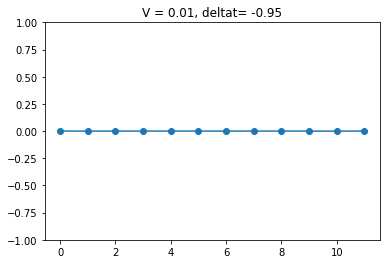

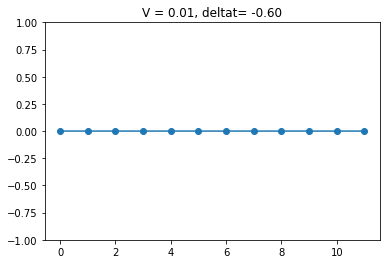

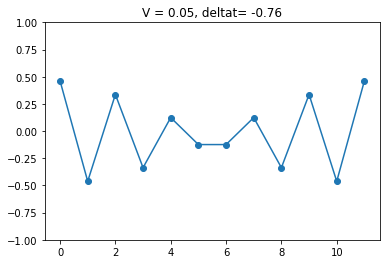

In [22]:
L = 12
psi_array = np.load('data/BH_MPS_L%.0f_logV_50x50.npy' %L, allow_pickle=True)

V_list = np.logspace(-2,2,50)
deltat_list = np.linspace(-0.95,0.95,50)

psi = psi_array[0][0]
plt.figure()
plt.ylim(-1,1)
plt.plot(psi.expectation_value('dN'), 'o-')
plt.title('V = %.2f, deltat= %.2f' %(V_list[0], deltat_list[0]))

psi = psi_array[49][0]
plt.figure()
plt.ylim(-1,1)
plt.plot(psi.expectation_value('dN'), 'o-')
plt.title('V = %.2f, deltat= %.2f' %(V_list[0], deltat_list[9]))

psi = psi_array[25][49]
plt.figure()
plt.ylim(-1,1)
plt.plot(psi.expectation_value('dN'), 'o-')
plt.title('V = %.2f, deltat= %.2f' %(V_list[9], deltat_list[5]))

# L = 11

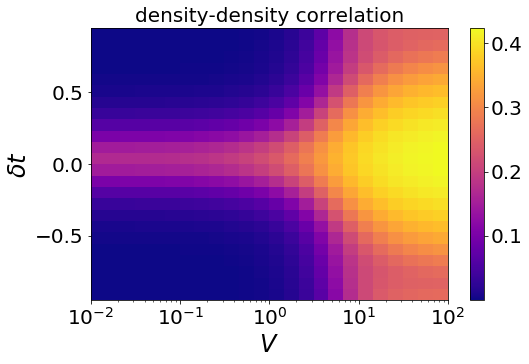

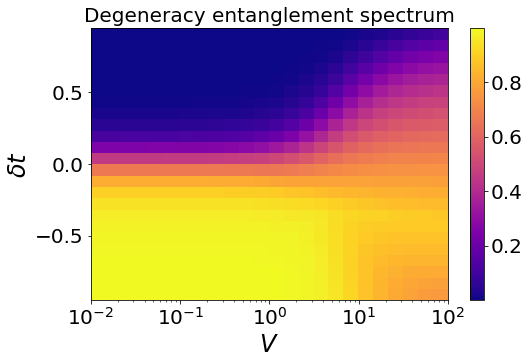

In [20]:
L = 11
psi_array = np.load('data/BH_MPS_L%.0f_logV_25x25.npy' %L, allow_pickle=True)

V_list = np.logspace(-2,2,25)
deltat_list = np.linspace(-0.95,0.95,25)

ES_array = []
parity_array = []
dd_array = []

for j,deltat in enumerate(deltat_list):
    
    ES_list = []
    parity_list = []
    dd_list = []

    psi_list = psi_array[j]
    
    for i,V in enumerate(V_list):
        
        psi = psi_list[i]
    
        ES = np.exp(-np.array(psi.entanglement_spectrum()[int(L/2)]))
        dES = -np.sum(ES[::2])+np.sum(ES[1::2])
        ES_list.append(dES)
        
        dd = 0
        for dd_el in psi.expectation_value('dN')[3:L-3]:
            dd += (-1)**i*dd_el
        #dd = np.sum(abs(psi.expectation_value('dN')[3:L-3]))
        dd_list.append(dd)
        
    dd_array.append(dd_list)
    ES_array.append(ES_list)
    
fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(dd_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("density-density correlation",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
plt.xscale("log")

fig,ax = plt.subplots(figsize=(8,5))
cmap = plt.get_cmap("plasma") #'viridis'
im = ax.pcolormesh(V_list, deltat_list, np.abs(ES_array), cmap=cmap)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
ax.set_title("Degeneracy entanglement spectrum",fontsize=20)
ax.set_xlabel(r"$V$",fontsize=24)
ax.set_ylabel(r"$\delta t$",fontsize=24)
ax.tick_params(labelsize=20)
plt.xscale("log")

Text(0.5, 1.0, 'V = 0.32, deltat= -0.55')

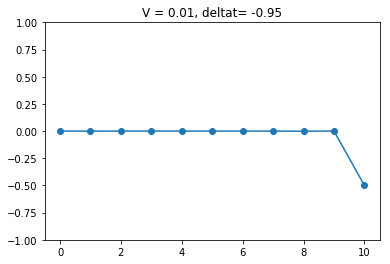

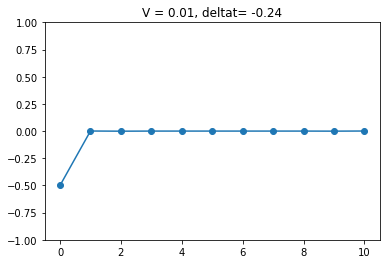

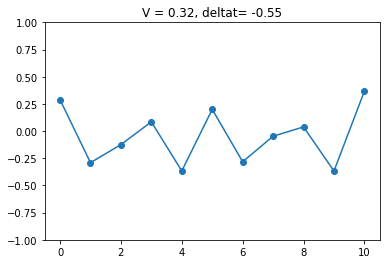

In [21]:
L = 11
psi_array = np.load('data/BH_MPS_L%.0f_logV_25x25.npy' %L, allow_pickle=True)

V_list = np.logspace(-2,2,25)
deltat_list = np.linspace(-0.95,0.95,25)

psi = psi_array[0][0]
plt.figure()
plt.ylim(-1,1)
plt.plot(psi.expectation_value('dN'), 'o-')
plt.title('V = %.2f, deltat= %.2f' %(V_list[0], deltat_list[0]))

psi = psi_array[24][0]
plt.figure()
plt.ylim(-1,1)
plt.plot(psi.expectation_value('dN'), 'o-')
plt.title('V = %.2f, deltat= %.2f' %(V_list[0], deltat_list[9]))

psi = psi_array[15][24]
plt.figure()
plt.ylim(-1,1)
plt.plot(psi.expectation_value('dN'), 'o-')
plt.title('V = %.2f, deltat= %.2f' %(V_list[9], deltat_list[5]))